# BERT命名实体识别NER

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源代码和数据集下载链接。

命名实体识别NER任务是NLP的一个常见任务，

它是Named Entity Recognization的简称。

简单地说，就是识别一个句子中的各种 名称实体，诸如：人名，地名，机构 等。

例如对于下面这句话：

```
小明对小红说:"你听说过安利吗？"
```

它的NER抽取结果如下:

```
[{'entity': 'person',
  'word': '小明',
  'start': 0,
  'end': 2},
 {'entity': 'person',
  'word': '小红',
  'start': 3,
  'end': 5},
 {'entity': 'organization',
  'word': '安利',
  'start': 12,
  'end': 14}】

```

本质上NER是一个token classification任务， 需要把文本中的每一个token做一个分类。

那些不是命名实体的token，一般用大'O'表示。

值得注意的是，由于有些命名实体是由连续的多个token构成的，为了避免有两个连续的相同的命名实体无法区分，需要对token是否处于命名实体的开头进行区分。

例如，对于 '我爱北京天安门' 这句话。如果我们不区分token是否为命名实体的开头的话，可能会得到这样的token分类结果。

'''
我(O) 爱(O) 北(Loc) 京(Loc) 天(Loc) 安(Loc) 门(Loc)
'''

然后我们做后处理的时候，把类别相同的token连起来，会得到一个location实体 '北京天安门'。


但是，’北京‘ 和 ’天安门‘ 是两个不同的location实体，把它们区分开来更加合理一些. 因此我们可以这样对token进行分类。

我(O) 爱(O) 北(B-Loc) 京(I-Loc) 天(B-Loc) 安(I-Loc) 门(I-Loc)

我们用 B-Loc表示这个token是一个location实体的开始token，用I-Loc表示这个token是一个location实体的内部(包括中间以及结尾)token. 这样，我们做后处理的时候，就可以把 B-loc以及它后面的 I-loc连成一个实体。这样就可以得到’北京‘ 和 ’天安门‘ 是两个不同的location的结果了。

区分token是否是entity开头的好处是我们可以把连续的同一类别的的命名实体进行区分，坏处是分类数量会几乎翻倍(n+1->2n+1)。
在许多情况下，出现这种连续的同命名实体并不常见，但为了稳妥起见，区分token是否是entity开头还是十分必要的。

## 一，准备数据

公众号算法美食屋后台回复关键词：torchkeras，获取本文notebook代码和车道线数据集下载链接。

In [1]:
import numpy as np 
import pandas as pd 

from transformers import BertTokenizer
from torch.utils.data import DataLoader,Dataset 
from transformers import DataCollatorForTokenClassification
import datasets  



### 1，数据加载

In [3]:
datadir = "./data/cluener_public/"

train_path = datadir+"train.json"
val_path = datadir+"dev.json"

dftrain = pd.read_json(train_path,lines=True)
dfval = pd.read_json(train_path,lines=True)

entities = ['address','book','company','game','government','movie',
              'name','organization','position','scene']

label_names = ['O']+['B-'+x for x in entities]+['I-'+x for x in entities]

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}


In [4]:
text = dftrain["text"][43]
label = dftrain["label"][43]

print(text)
print(label)

世上或许有两个人并不那么喜欢LewisCarroll的原著小说《爱丽斯梦游奇境》(
{'book': {'《爱丽斯梦游奇境》': [[31, 39]]}, 'name': {'LewisCarroll': [[14, 25]]}}


### 2，文本分词

In [5]:
from transformers import BertTokenizer
model_name = 'bert-base-chinese'
tokenizer = BertTokenizer.from_pretrained(model_name) 
print(tokenizer) 

BertTokenizer(name_or_path='bert-base-chinese', vocab_size=21128, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


In [6]:
tokenized_input = tokenizer(text)
print(tokenized_input["input_ids"])

[101, 686, 677, 2772, 6387, 3300, 697, 702, 782, 2400, 679, 6929, 720, 1599, 3614, 100, 4638, 1333, 5865, 2207, 6432, 517, 4263, 714, 3172, 3457, 3952, 1936, 1862, 518, 113, 102]


In [7]:
#可以从id还原每个token对应的字符组合
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
for t in tokens:
    print(t)

[CLS]
世
上
或
许
有
两
个
人
并
不
那
么
喜
欢
[UNK]
的
原
著
小
说
《
爱
丽
斯
梦
游
奇
境
》
(
[SEP]


### 3，标签对齐

可以看到，经过文本分词后的token长度与文本长度并不相同，

主要有以下一些原因导致：一是BERT分词后会增加一些特殊字符如 `[CLS]`,`[SEP]`

二是，还会有一些英文单词的subword作为一个 token. (如这个例子中的 'charles')，

此外，还有一些未在词典中的元素被标记为`[UNK]`会造成影响。

因此需要给这些token赋予正确的label不是一个容易的事情。

我们分两步走，第一步，把原始的dict形式的label转换成字符级别的char_label

第二步，再将char_label对齐到token_label

In [8]:
# 把 label格式转化成字符级别的char_label
def get_char_label(text,label):
    char_label = ['O' for x in text]
    for tp,dic in label.items():
        for word,idxs in dic.items():
            idx_start = idxs[0][0]
            idx_end = idxs[0][1]
            char_label[idx_start] = 'B-'+tp
            char_label[idx_start+1:idx_end+1] = ['I-'+tp for x in range(idx_start+1,idx_end+1)]
    return char_label 


In [9]:
char_label = get_char_label(text,label)
for char,char_tp in zip(text,char_label):
    print(char+'\t'+char_tp)

世	O
上	O
或	O
许	O
有	O
两	O
个	O
人	O
并	O
不	O
那	O
么	O
喜	O
欢	O
L	B-name
e	I-name
w	I-name
i	I-name
s	I-name
C	I-name
a	I-name
r	I-name
r	I-name
o	I-name
l	I-name
l	I-name
的	O
原	O
著	O
小	O
说	O
《	B-book
爱	I-book
丽	I-book
斯	I-book
梦	I-book
游	I-book
奇	I-book
境	I-book
》	I-book
(	O


In [10]:
def get_token_label(text, char_label, tokenizer):
    tokenized_input = tokenizer(text)
    tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
    
    iter_tokens = iter(tokens)
    iter_char_label = iter(char_label)  
    iter_text = iter(text.lower()) 

    token_labels = []

    t = next(iter_tokens)
    char = next(iter_text)
    char_tp = next(iter_char_label)

    while True:
        #单个字符token(如汉字)直接赋给对应字符token
        if len(t)==1:
            assert t==char
            token_labels.append(char_tp)   
            try:
                char = next(iter_text)
                char_tp = next(iter_char_label)
            except StopIteration:
                pass  

        #添加的特殊token如[CLS],[SEP],排除[UNK]
        elif t in tokenizer.special_tokens_map.values() and t!='[UNK]':
            token_labels.append('O')              


        elif t=='[UNK]':
            token_labels.append(char_tp) 
            #重新对齐
            try:
                t = next(iter_tokens)
            except StopIteration:
                break 

            if t not in tokenizer.special_tokens_map.values():
                while char!=t[0]:
                    try:
                        char = next(iter_text)
                        char_tp = next(iter_char_label)
                    except StopIteration:
                        pass    
            continue

        #其它长度大于1的token，如英文token
        else:
            t_label = char_tp
            t = t.replace('##','') #移除因为subword引入的'##'符号
            for c in t:
                assert c==char or char not in tokenizer.vocab
                if t_label!='O':
                    t_label=char_tp
                try:
                    char = next(iter_text)
                    char_tp = next(iter_char_label)
                except StopIteration:
                    pass    
            token_labels.append(t_label) 

        try:
            t = next(iter_tokens)
        except StopIteration:
            break  
            
    assert len(token_labels)==len(tokens)
    return token_labels 
    

In [11]:
token_labels = get_token_label(text,char_label,tokenizer)


In [12]:
for t,t_label in zip(tokens,token_labels):
    print(t,'\t',t_label)
    

[CLS] 	 O
世 	 O
上 	 O
或 	 O
许 	 O
有 	 O
两 	 O
个 	 O
人 	 O
并 	 O
不 	 O
那 	 O
么 	 O
喜 	 O
欢 	 O
[UNK] 	 B-name
的 	 O
原 	 O
著 	 O
小 	 O
说 	 O
《 	 B-book
爱 	 I-book
丽 	 I-book
斯 	 I-book
梦 	 I-book
游 	 I-book
奇 	 I-book
境 	 I-book
》 	 I-book
( 	 O
[SEP] 	 O


### 4，构建管道

In [13]:
dftrain.head() 

,text,label
0,浙商银行企业信贷部叶老桂博士则从另一个角度对五道门槛进行了解读。叶老桂认为，对目前国内商业银...,"{'name': {'叶老桂': [[9, 11]]}, 'company': {'浙商银行..."
1,生生不息CSOL生化狂潮让你填弹狂扫,"{'game': {'CSOL': [[4, 7]]}}"
2,那不勒斯vs锡耶纳以及桑普vs热那亚之上呢？,"{'organization': {'那不勒斯': [[0, 3]], '锡耶纳': [[6..."
3,加勒比海盗3：世界尽头》的去年同期成绩死死甩在身后，后者则即将赶超《变形金刚》，,"{'movie': {'加勒比海盗3：世界尽头》': [[0, 11]], '《变形金刚》'..."
4,布鲁京斯研究所桑顿中国中心研究部主任李成说，东亚的和平与安全，是美国的“核心利益”之一。,"{'address': {'美国': [[32, 33]]}, 'organization'..."


In [14]:
def make_sample(text,label,tokenizer):
    sample = tokenizer(text)
    char_label = get_char_label(text,label)
    token_label = get_token_label(text,char_label,tokenizer)
    sample['labels'] = [label2id[x] for x in token_label]
    return sample 

In [15]:
from tqdm import tqdm 
train_samples = [make_sample(text,label,tokenizer) for text,label in 
                 tqdm(list(zip(dftrain['text'],dftrain['label'])))]
val_samples = [make_sample(text,label,tokenizer) for text,label in 
                 tqdm(list(zip(dfval['text'],dfval['label'])))]


100%|██████████| 10748/10748 [00:06<00:00, 1711.10it/s]


In [16]:
ds_train = datasets.Dataset.from_list(train_samples)
ds_val = datasets.Dataset.from_list(val_samples)


In [17]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
dl_train = DataLoader(ds_train,batch_size=8,collate_fn=data_collator)
dl_val = DataLoader(ds_val,batch_size=8,collate_fn=data_collator)



In [136]:
for batch in dl_train:
    break 

## 二，定义模型

In [137]:
from transformers import BertForTokenClassification

net = BertForTokenClassification.from_pretrained(
    model_name,
    id2label=id2label,
    label2id=label2id,
)

#冻结bert基模型参数
for para in net.bert.parameters():
    para.requires_grad_(False)

print(net.config.num_labels) 

#模型试算
out = net(**batch)
print(out.loss) 
print(out.logits.shape)  



Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: 

21
tensor(3.0772, grad_fn=<NllLossBackward0>)
torch.Size([8, 52, 21])


## 三，训练模型

In [138]:
import torch 
from torchkeras import KerasModel 

#我们需要修改StepRunner以适应transformers的数据集格式

class StepRunner:
    def __init__(self, net, loss_fn, accelerator, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        out = self.net(**batch)
        
        #loss
        loss= out.loss
        
        #preds
        preds =(out.logits).argmax(axis=2) 
    
        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
        
        all_loss = self.accelerator.gather(loss).sum()
        
        labels = batch['labels']
        
        #precision & recall
        
        precision =  (((preds>0)&(preds==labels)).sum())/(
            torch.maximum((preds>0).sum(),torch.tensor(1.0).to(preds.device)))
        recall =  (((labels>0)&(preds==labels)).sum())/(
            torch.maximum((labels>0).sum(),torch.tensor(1.0).to(labels.device)))
    
        
        all_precision = self.accelerator.gather(precision).mean()
        all_recall = self.accelerator.gather(recall).mean()
        
        f1 = 2*all_precision*all_recall/torch.maximum(
            all_recall+all_precision,torch.tensor(1.0).to(labels.device))
        
        #losses
        step_losses = {self.stage+"_loss":all_loss.item(), 
                       self.stage+'_precision':all_precision.item(),
                       self.stage+'_recall':all_recall.item(),
                       self.stage+'_f1':f1.item()
                      }
        
        #metrics
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


In [158]:
optimizer = torch.optim.AdamW(net.parameters(), lr=3e-5)

keras_model = KerasModel(net,
                   loss_fn=None,
                   optimizer = optimizer
                   )


<<<<<< ⚡️ cuda is used >>>>>>


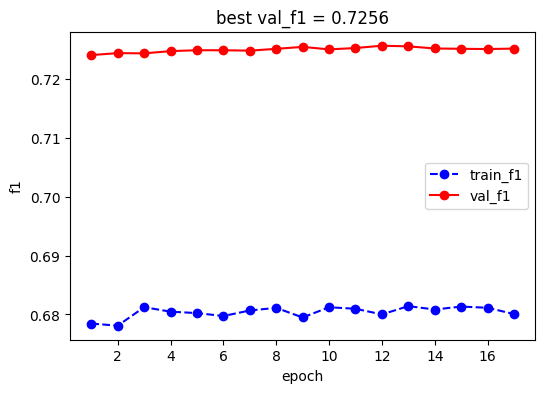

<<<<<< val_f1 without improvement in 5 epoch,early stopping >>>>>>


,epoch,train_loss,train_precision,train_recall,train_f1,lr,val_loss,val_precision,val_recall,val_f1
0,1,0.280753,0.661162,0.708562,0.678469,0.00003,0.233344,0.697657,0.763197,0.723983
1,2,0.280068,0.661054,0.707853,0.678095,0.00003,0.232841,0.698279,0.763289,0.724314
2,3,0.278366,0.663814,0.710813,0.681237,0.00003,0.232643,0.697586,0.763988,0.724272
3,4,0.278720,0.663917,0.709843,0.680477,0.00003,0.232322,0.698723,0.763469,0.724655
4,5,0.279467,0.662568,0.710921,0.680237,0.00003,0.232189,0.697799,0.764892,0.724802
5,6,0.278937,0.662431,0.710440,0.679740,0.00003,0.232076,0.697726,0.764980,0.724800
6,7,0.277210,0.663949,0.710058,0.680680,0.00003,0.231985,0.697693,0.764887,0.724733
7,8,0.278545,0.663654,0.711216,0.681124,0.00003,0.231924,0.697893,0.765281,0.725040
8,9,0.278285,0.662669,0.708992,0.679494,0.00003,0.231828,0.698353,0.765430,0.725370
9,10,0.277281,0.663959,0.710993,0.681228,0.00003,0.231806,0.697125,0.766040,0.724946


In [159]:
keras_model.fit(
    train_data = dl_train,
    val_data= dl_val,
    ckpt_path='bert_ner.pt',
    epochs=50,
    patience=5,
    monitor="val_f1", 
    mode="max",
    plot = True,
    wandb = False,
    quiet = True
)


## 四，评估模型

In [160]:
from torchmetrics import Accuracy

In [161]:
acc = Accuracy(task='multiclass',num_classes=21)
acc = keras_model.accelerator.prepare(acc)

dl_test = keras_model.accelerator.prepare(dl_val)
net = keras_model.accelerator.prepare(net)

In [164]:

from tqdm import tqdm 
for batch in tqdm(dl_test):
    with torch.no_grad():
        outputs = net(**batch)
        
    labels = batch['labels']
    labels[labels<0]=0
    #preds
    preds =(outputs.logits).argmax(axis=2) 
    acc.update(preds,labels)
    

100%|██████████| 1344/1344 [00:12<00:00, 107.75it/s]


In [165]:
acc.compute()  #这里的acc包括了 ’O‘的分类结果，存在高估。

tensor(0.9178, device='cuda:0')

## 五，使用模型

我们可以使用pipeline来串起整个预测流程.

注意我们这里使用内置的'simple'这个aggregation_strategy，

把应该归并的token自动归并成一个entity.


In [166]:
from transformers import pipeline

In [167]:
recognizer = pipeline("token-classification", 
                      model=net, tokenizer=tokenizer, aggregation_strategy='simple')

In [168]:
net.to('cpu');

In [169]:
recognizer('小明对小红说，“你听说过安利吗？”')

[{'entity_group': 'name',
  'score': 0.6913842,
  'word': '小 明',
  'start': None,
  'end': None},
 {'entity_group': 'name',
  'score': 0.58951116,
  'word': '小 红',
  'start': None,
  'end': None},
 {'entity_group': 'name',
  'score': 0.74060774,
  'word': '安 利',
  'start': None,
  'end': None}]

## 六，保存模型

保存model和tokenizer之后，我们可以用一个pipeline加载，并进行批量预测。

In [170]:
net.save_pretrained("ner_bert")
tokenizer.save_pretrained("ner_bert")


('ner_bert/tokenizer_config.json',
 'ner_bert/special_tokens_map.json',
 'ner_bert/vocab.txt',
 'ner_bert/added_tokens.json')

In [171]:
recognizer = pipeline("token-classification", 
                      model="ner_bert",
                      aggregation_strategy='simple')

In [172]:
recognizer('小明对小红说，“你听说过安利吗？”')

[{'entity_group': 'name',
  'score': 0.6913842,
  'word': '小 明',
  'start': 0,
  'end': 2},
 {'entity_group': 'name',
  'score': 0.58951116,
  'word': '小 红',
  'start': 3,
  'end': 5},
 {'entity_group': 'name',
  'score': 0.74060774,
  'word': '安 利',
  'start': 12,
  'end': 14}]

**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)